# [Bayesian Thermostat](https://www.frontiersin.org/journals/robotics-and-ai/articles/10.3389/frobt.2019.00020/full) Agent-Environment Simulation

# Notes:

* Wouter's current strategy:
    - Have ```update!``` return ```nothing``` for the agent.
    - Have ```emits``` as ```false``` for the agent.
    - Handle inference outside the RxEnvs Entity loop.
* The user never calls any of the RxEnvs Entity functions, except for ```send!```.
     - ```send!``` triggers the 5 Entity functions for the receiving entity.
* The global sensor-motor/agent-environment subscription loop will look something like this, for the discrete time case:

```julia
# use a keep actor to get observations
observations = RxEnvironments.keep(Any)

# subscribe to the observations so that they are available in the 'synchronous' loop
RxEnvironments.subscribe_to_observations!(agent, observations)

for i in 1:T
    
    # get the current observation
    current_observation = RxEnvironments.data(
        last(observations)
    )[1]
    
    # do inference
    result = infer(
        model = aif_model(
            prior_transition_ps = transition_ps, 
            target = target, 
            T = T
        ), 
        data = (
            current_s = current_observation, 
            prev_s = prev_s, 
            prev_a = prev_a
        )
    )
    
    # extract the inference result
    # this consists in the updated posteriors on transition probabilities 
    # and the inferred action 
    transition_ps = last(result.posteriors[:p]) # Update learned transition probabilities
    a = mean(first(last(result.posteriors[:actions]))) # What action do we have to do
    prev_s = current_observation
    
    sleep(0.01)
    
    # send! the action to the environment
    # send!(recipient::AbstractEntity, emitter::AbstractEntity, action::Any)
    if a == 1
        RxEnvironments.send!(env, agent, TMazeAgentAction(North()))
    elseif a == 2
        RxEnvironments.send!(env, agent, TMazeAgentAction(East()))
    elseif a == 3
        RxEnvironments.send!(env, agent, TMazeAgentAction(South()))
    elseif a == 4
        RxEnvironments.send!(env, agent, TMazeAgentAction(West()))
    end
    
    prev_a = a
end
```

* we should stick with the discrete time case for now and then move to the 'truly' reactive case. An example of the latter is the [Infinite Data Stream](https://reactivebayes.github.io/RxInfer.jl/stable/examples/advanced_examples/Infinite%20Data%20Stream/) example from RxInfer.jl. 
    - In the 'truly' reactive case all you really have to do is (similarly to this example), subscribe to the posterior of whatever action variable you have in your model, and send! this back to your environment. 
* A "discrete time" environment is one for which ```elapsed_time``` is constant. When a discrete time environment receives an action, the environment dynamics will step forward by a predetermined amount of time and no actions will be accepted in between. 
    - Specify a discrete environment with the ```is_discrete``` field of ```create_entity```.
    - See the RxInfer.jl example of discrete time [Mountain Car](https://biaslab.github.io/RxEnvironments.jl/stable/lib/example_mountaincar/#Discrete-time-Mountain-Car).
* The environment should be ```active``` - otherwise it will only listen. 
* Agent shouldn't be ```active``` - not sure about this.
* For all ```RxEnvironments``` functions, you don't have to dispatch on ```RxEntity``` types.
    - ```ThermostatAgent``` and ```ThermostatEnv``` is probably enough. 
* Don't really need to define ```what_to_send``` for the agent. Already do the inference and the sending in the main loop. 
* ```receive!``` should be whatever you want to do with your noisy observation, but because you funnel this observation through an RxEnvironments.keep actor outside of RxEnvironments, you might not even have to define it at all as well.

# Questions:

* You say that ```emits``` for the agent should just be ```nothing``` and yet, in the paper you have defined two ```emits``` functions for the agent.
    - I wonder if this also applies to the environment's ```emits``` function/s?
* Looks like the type for most things should be ```AbstractEntity```. This is NOT what I have now.
* What is ```RxEnvironments.data()```? It seems to be a way to get an observation.
* The agent's ```receive!``` function should juet be the environmental observation of the temp?
* Given that the agent's control logic will all be handled in the main loop for now, should the agent be a passive entity?

### Using [RxInfer.jl](https://rxinfer.ml/) and [RxEnvironments.jl](https://biaslab.github.io/RxEnvironments.jl/stable/)

In [40]:
using RxInfer
using RxEnvironments
using Distributions
using Plots
using GLMakie

# Problem Description

This problem and agent specification is taken from [this paper](https://www.frontiersin.org/journals/robotics-and-ai/articles/10.3389/frobt.2019.00020/full). 

The general setup is that we have an agent which is supposed to perform the task of a thermostat. Our agent is mobile and can perform the sole action of moving left or right along the real interval $[0, E_p]$, where $E_p > 0$ is the endpoint of the interval. The agent's only action affordance, $a_t$ will be to set its velocity at time $t$.Our agent takes a position in the interval at time $t$, given by $z_t \in [0, E_p]$. 

We suppsoe that there is a single heat source at the origin, outputing $T_0 = 100.0$ units of temperature. This heat source results in a temperature distribution on the interval, given by $T(z_t)$ which we specify below. The agent can observe a noisy measurement of the true temperature - given by $x_t$ - at its current position: $z_t$.

The agent's task is to infer the actions that result in it observing a prefered temperatrue of $x^*$, where $x^* = 4.0$. 

# Assumptions 

We assume that the environmental process consists of two things: the closed interval: $I(E_p) = [0, E_p]$, where $E_p > 0$ is the end point of the interval, and a function defined on this interval:

\begin{equation}
    T(z) = \frac{T_0}{z^2 + 1}
\end{equation}

Which specifies the temperature distribution on the interval. As mentioned above, $z_t$ is the agent's position in the environment's interval and $T_0$ is the temperature at $z_t = 0$. We will use $T_0 = 100.0$. 

The environmental process is steered by actions $a_t$ that reflect the velocity of the agent. The output of the environmental process is the observed temperature by the agent. We assume that the agent observes a noisy temperature: $x_t$, leading to the following environmental process equations:

\begin{equation}
    z_t = z_{t - 1} + a_t
\end{equation}

We also assume that the agent observes a noisy temperature:

\begin{equation}
    x_t \sim \mathcal{N}(T(z_t), \vartheta)
\end{equation}

Where we specify the following observation noise variance: $\vartheta = 10^{-2}$. 

## [Environment Specification](https://biaslab.github.io/RxEnvironments.jl/stable/lib/getting_started/#lib-started) with RxEnvironments.jl

In [41]:
"""
Models the distribution of temperature in an interval.

The origin is supposed as the only source of the temperatrue 
and source_temp is the temperature at this source. 
"""
function temperature(position, source_temp)
    return source_temp / (position^2 + 1)
end

temperature

In [42]:
mutable struct BayesianThermostatEnv
    source_temp::Float64
    interval_end_point::Float64
    interval_incr_stepsize::Float64
    temperature_distribution::Function
    interval::Vector{Float64}
    obs_noise_variance::Float64
    # ADD AGENT POSITION ???????

    # Constructor with default values
    BayesianThermostatEnv(
        source_temp::Float64 = 100.0,
        interval_end_point::Float64 = 16.0,
        interval_incr_stepsize::Float64 = 0.01,
        obs_noise_variance::Float64 = 0.7
    ) = new(
        source_temp,
        interval_end_point, 
        interval_incr_stepsize, 
        temperature, 
        collect(0.0:interval_incr_stepsize:interval_end_point),
        obs_noise_variance
    )
end

In [43]:
# Helper functions
noise(
    env::BayesianThermostatEnv
) = Normal(0.0, env.obs_noise_variance)

exact_temperature(
    env::BayesianThermostatEnv, 
    agent_position::Float64
) = env.temperature_distribution(agent_position, env.source_temp)

noisy_temperature(
    env::BayesianThermostatEnv, 
    agent_position::Float64
) = env.temperature_distribution(agent_position, env.source_temp) + rand(noise(env))

noisy_temperature (generic function with 1 method)

In [44]:
# Create an instance of BayesianThermostatEnv
env = BayesianThermostatEnv(100.0)

BayesianThermostatEnv(100.0, 16.0, 0.01, temperature, [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  15.91, 15.92, 15.93, 15.94, 15.95, 15.96, 15.97, 15.98, 15.99, 16.0], 0.7)

# Make Environment "RxEnvironment" or "Entity"?

In [45]:
# wrap the env struct arround an RxEnvironments.AbstractEntity
# create_entity(env; is_discrete = false, is_active = false, real_time_factor = 1)
# env_entity = create_entity(env; is_discrete=false, is_active=false)

# env_entity = create_entity(env; is_discrete=true, is_active=false)
env_entity = create_entity(env; is_discrete=true, is_active=true)

Discrete RxEntity{BayesianThermostatEnv}

In [46]:
typeof(env_entity)

RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}

In [8]:
# Note: acess the decorated struct via the decorated field of RxEntity
# env_entity.decorated

In [47]:
# Generate temperature data
exact_temperatures = [exact_temperature(env, pos) for pos in env_entity.decorated.interval];  # Calculate exact temperatures
noisy_temperatures = [noisy_temperature(env, pos) for pos in env_entity.decorated.interval];  # Calculate noisy temperatures

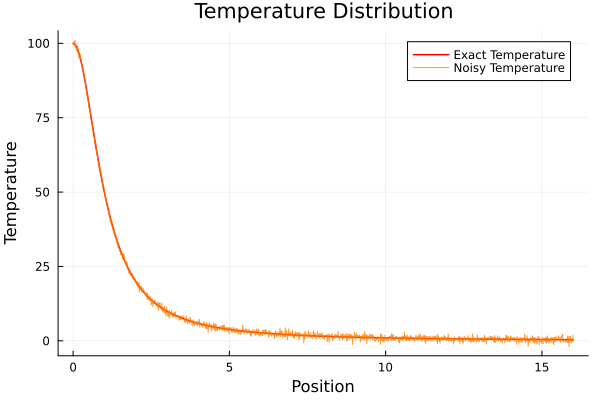

In [48]:
# a custom orange color
dark_orange = RGB(1.0, 0.5, 0.0)

# Plot exact temperatures
Plots.plot(
    env_entity.decorated.interval, 
    exact_temperatures, 
    linewidth = 1.5,
    color = "red", 
    label = "Exact Temperature", 
    title = "Temperature Distribution", 
    xlabel = "Position", 
    ylabel = "Temperature"
)

# Plot noisy temperatures
Plots.plot!(
    env_entity.decorated.interval, 
    noisy_temperatures, 
    linewidth = 1.0,
    alpha = 0.8,
    color = dark_orange, 
    label = "Noisy Temperature"
)

In [9]:
# # When the environment receives an action from the agent, we shouldn't emit back to the agent
# # NOT SURE ABOUT THIS
# RxEnvironments.emits(
#     subject = env::BayesianThermostatEnv, 
#     listener = agent::ThermostatAgent, 
#     observtion = observtion::Real
# ) = false

# # In any other case, we should emit (This line is obsolete since this is the default 
# # behavior, but we include itfor clarity)
# # NOT SURE ABOUT THIS
# RxEnvironments.emits(
#     subject = env::BayesianThermostatEnv, 
#     listener = agent::ThermostatAgent, 
#     observation = any
# ) = true

# # The environment sends a noisy temperature observation to the agent.
# RxEnvironments.what_to_send(
#     recipient = agent::ThermostatAgent,
#     emitter = env::BayesianThermostatEnv
# ) = noisy_temperature(emitter, recipient.position)

# # When the environment receives an action from the agent, nothng changes in the 
# # environment itself. The temperature distribution is supposed to be static. 
# RxEnvironments.receive!(
#     recipient = env::BayesianThermostatEnv,
#     emitter = agent::ThermostatAgent, 
#     action = action::Real
# ) = nothing
    
# # The environment is static across time.
# RxEnvironments.update!(
#     env::BayesianThermostatEnv, 
#     elapsed_time
# ) = nothing

## [Agent Specification](https://www.frontiersin.org/journals/robotics-and-ai/articles/10.3389/frobt.2019.00020/full) with RxInfer.jl

Almost all of the following text was taken word-for-word from the paper listed above in the problem description.

### Generative Model:

We consider an agent with a state-space model (SSM) factorization for its internal model, given by:

\begin{equation}
    p_t(x, s, u) \propto p(s_{t-1})\prod_{k = t}^{t + T}p(x_k | s_k)p(s_k | s_{k - 1}, u_k)p(u_k)p'(x_k)
\end{equation}

where $x$, $s$, and $u$ are sequences of observations, hidden states and controls (respectively). All three of these resepctive sequences have ranges that are implicitly given by the model specification at the right-hand side. Note how the model of this Equation differs slightly from a standard SSM factorization, because it includes additional “target” priors $p'(x_k)$ over desired future outcomes. Also note that the probability distribution for the internal model has a subscript $t$ to indicate that the model is time-varying.

Also note that at time step t, the agent has assumptions about how the environment will evolve over the next $T + 1$ time steps since we can run this model forward and generate observations $x_k$ for $k = t, t + 1, …, t + T$. The horizon T is determined by the information content of the target priors $p'(x_k)$. These target priors are generally set by states of contextual processes, i.e., not by this agent but rather by other agents (or higher level processes) that encode unsurprising future outcomes for this agent. In order to distinguish the predictive model for observations $p(x_k | s_k)$ from the context-based target prior for observations $p'(x_k)$, we label the latter factor with a prime.

We refer to a sequence of future controls $u = (u_t, u_{t + 1}, ..., u_{t + T})$ as a "policy". Through inference, the posterior over policies becomes dependent on the hidden state sequence $s$. Prior to inference however, the model requires the definition of a prior belief over policies that constrains attainable control states. In a more general formulation of the internal model, we would write a prior over policies: $p(u) = p(u_t, u_{t + 1}, ..., u_{t + T})$. Here, for simplicity, we assume:

\begin{equation}
    p(u) = \prod_{k = t}^{t + T}p(u_k)
\end{equation}

### Variational Model:
Next to the internal (generative model) model, we assume that the agent has access to a variational distribution, also known as the recognition distribution:

\begin{equation}
    q_t(x, s, u)
\end{equation}

that encodes the agent's posterior beliefs about all latent states. Because the future is by definition unobserved, the recognition distribution includes the future observation variables as well. The distinction between the agent's prior (“generative”) beliefs $p_t(x, s, u)$ and posterior (“recognition”) beliefs $q_t(x,s, u)$ will be finessed below.

At the start of the simulation (say at $t = 1$), we will set $q_1$ to an uninformative distribution. As time progresses, observations become available and subsequent inference iterations will tune $q_t$ to more informed distributions. Often, but not necessarily so, the recognition distribution is assumed to be fully factorized (this is the mean-field assumption). In the present article we assume a structured factorization for the recognition distribution that is solely induced by the internal model factorization. In general, we may write:

\begin{equation}
    q_t(x, s, u) = q(x, s | u)q(u)
\end{equation}

Since actions onto the environment are real-valued interventions, we will generally enforce a deterministic posterior belief over policies, i.e.,

\begin{equation}
    q(u_t, ..., u_{t + T}) = \prod_{k = t}^{t + T} \delta(u_k - \upsilon_k)
\end{equation}

where $\upsilon_k$ (upsilon) are parameters that are to be determined in the free-energy minimization process. In other words, while the prior belief over policies $p(u)$ may contain uncertainties, we will fix the posterior belief over policies $q(u)$ on a single concrete sequence.

As time progresses, at each time step, the agent interacts with its environment through exchanging actions and observations, followed by processing the observations. Technically, everything that the agents does can be described as updates to its internal and recognition models.

### Model Specification:

#### Initial Position:
The agent shall start at position $z_0 = 2.0$ in the environmental interval. 

#### Goal Prior Model:
The agent's goal prior over observations $p'(x_k)$ encodes a belief about a preferred temperature observation. Let the agent's prefered temperature observation be denoted as $x_*$. We set agent's prefered temperature observation to be $4.0$. hence:

\begin{equation}
    p'(x_k) = \mathcal{N}(x_k | x_*, 10^{-2})
\end{equation}

#### System Dynamics Model:
Furthermore, we endow the agent with an accurate model of system dynamics:

\begin{equation}
    p(s_k | s_{k - 1}, u_k) = \mathcal{N}(s_k | s_{k - 1} + u_k, 10^{-2})
\end{equation}

#### Observation Model:
However, in order to challenge the agent, we hamper the observation model. Instead of the actual temperature profile $y_t \sim \mathcal{N}(T(z_t), \vartheta)$, we use:

\begin{equation}
    p(x_k | s_k) = \mathcal{N}(x_k | - s_k, 10^{-2})
\end{equation}

which simply specifies that the observed temperature decreases with position. This is true of course, but this is a significant "coarse-graining" of the full situation - given by the above specified temperature function: $T(z)$.  

#### Control Model and Initial State:
We specify a prior for controls:

\begin{equation}
    p(u_k) = \mathcal{N}(u_k | 0, 10^{-2})
\end{equation}

and a vague prior for the initial state:

\begin{equation}
    p(s_0) = \mathcal{N}(s_0 | 0, 10^{12})
\end{equation}

This fully defines the agent's internal model: $p_t(x, s, u)$.

## Agent Specification with RxInfer.jl

In [49]:
# The agent is specified via its generative model. 
mutable struct ThermostatAgent 
    position::Float64 # the agent's position in the interval
    infered_action::Float64 # the action that the agent has inferred 
    observed_temp::Float64

    # Constructor with default values
    ThermostatAgent(
        position::Float64 = 2.0, # initial position
        infered_action::Float64 = 0.0, # initial action is 0.0 (for no effect)
        observed_temp::Float64 = temperature(position, 100.0) + rand(Normal(0.0, 0.7))
    ) = new(
        position, 
        infered_action,
        observed_temp
    )
end

## Environment Entity API

In [50]:
RxEnvironments.emits(
    subject::BayesianThermostatEnv, # env
    listener::ThermostatAgent, # agent
    observation::Real
) = false

RxEnvironments.emits(
    subject::BayesianThermostatEnv, # env
    listener::ThermostatAgent, # agent
    observation::Any
) = true

RxEnvironments.what_to_send(
    recipient::ThermostatAgent, # agent
    emitter::BayesianThermostatEnv, # env
) = noisy_temperature(emitter.decorated, recipient.decorated.position)

RxEnvironments.receive!(
    recipient::BayesianThermostatEnv, # env
    emitter::ThermostatAgent, # agent
    action::Real
) = nothing

RxEnvironments.update!(
    e::BayesianThermostatEnv, # env
    elapsed_time::Real
) = nothing


## SECOND VERSION:
# RxEnvironments.emits(
#     subject::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}, # env
#     listener::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.ContinuousEntity, RxEnvironments.ActiveEntity, Any}, # agent
#     observation::Real
# ) = false

# RxEnvironments.emits(
#     subject::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}, # env
#     listener::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.ContinuousEntity, RxEnvironments.ActiveEntity, Any}, # agent
#     observation::Any
# ) = true

# RxEnvironments.what_to_send(
#     recipient::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}, # agent
#     emitter::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}, # env
# ) = noisy_temperature(emitter.decorated, recipient.decorated.position)

# RxEnvironments.receive!(
#     recipient::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}, # env
#     emitter::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}, # agent
#     action::Real
# ) = nothing

# RxEnvironments.update!(
#     e::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}, # env
#     elapsed_time::Real
# ) = nothing




## OG VERSION:
# RxEnvironments.emits(
#     subject::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.PassiveEntity, Any}, # env
#     listener::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.ContinuousEntity, RxEnvironments.ActiveEntity, Any}, # agent
#     observation::Real
# ) = false

# RxEnvironments.emits(
#     subject::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.PassiveEntity, Any}, # env
#     listener::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.ContinuousEntity, RxEnvironments.ActiveEntity, Any}, # agent
#     observation::Any
# ) = true

# RxEnvironments.what_to_send(
#     recipient::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}, # agent
#     emitter::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.PassiveEntity, Any} # env
# ) = noisy_temperature(emitter.decorated, recipient.decorated.position)

# RxEnvironments.receive!(
#     recipient::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.PassiveEntity, Any}, # env
#     emitter::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}, # agent
#     action::Real
# ) = nothing

# RxEnvironments.update!(
#     e::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.PassiveEntity, Any}, # env
#     elapsed_time::Real
# ) = nothing

In [11]:
# Modeled after the existing Mountain Car @model: 
# https://reactivebayes.github.io/RxInfer.jl/stable/examples/advanced_examples/Active%20Inference%20Mountain%20car/
# The analytic form of the generative model is the same, so it seems like it should be a 
# reasonably analogous @model. 

# # Arguments
# - m_x: Mean of the goal prior observation.
# - V_x: Variance of the goal prior observation.
# - m_s_t: Mean of the system state dynamics.
# - V_s_t: Variance of the system state dynamics.
# - m_u: Mean of the control prior.
# - V_u: Variance of the control prior.
# - T: Planning horizon, default is 3.

# # Returns
# - The instantiated Bayesian thermostat model, in addition to posteriors over s, x and u.
@model function bayesian_thermostat_model_1(
        m_x, V_x,
        m_s_t, V_s_t,
        m_u, V_u,
        T # plan over a future time horizon of 3 steps
    )
    
    # Initial action prior:
    u[1] ~ Normal(mean = m_u[1], variance = V_u[1])

    # Initial state prior:
    s_t ~ Normal(mean = m_s_t, variance = V_s_t)
    s_k = s_t
    s[1] = s_k
    local s
    
    # Initial observation prior:
    x[1] ~ Normal(mean = m_x[1], variance = 1e-2)
    
    # Observation-goal prior:
    x_goal[1] ~ Normal(mean = m_x[1], variance = V_x[1])
    
    # State dynamics:
    for k in 2:T
        u[k] ~ MvNormal(mean = m_u[k], variance = V_u[k])
        s[k] ~ Normal(mean = s[k - 1] + u[k], variance = 1e-2)
        x[x] ~ Normal(mean = -s[k], variance = 1e-2)
        x_goal[k] ~ Normal(mean = m_x[k], variance = V_x[k]) # goal prior
        s_k = s[k] # proceed to the next state in the time horizon
    end

    return (s, x, u)
end

In [51]:
# Modeled after the existing Drone navigation @model: 
# https://github.com/ReactiveBayes/RxInferExamples.jl/blob/main/drone/drone_simulation.ipynb

# # Arguments
# - m_x: Mean of the goal prior observation.
# - V_x: Variance of the goal prior observation.
# - m_s_t: Mean of the system state dynamics.
# - V_s_t: Variance of the system state dynamics.
# - m_u: Mean of the control prior.
# - V_u: Variance of the control prior.
# - T: Planning horizon, default is 3.

# # Returns
# - The instantiated Bayesian thermostat model, in addition to posteriors over s, x and u.
@model function bayesian_thermostat_model_2(
        agent,
        observation_t,
        T # plan over a future time horizon of 3 steps
    )
    
    # Initial action prior:
    u[1] ~ Normal(mean = 0.0, variance = 1e-2)

    # Initial state prior:
    s_t ~ Normal(mean = agent.position, variance = 1e-2) # initial state prior is centered on the current position
    s_k = s_t
    s[1] = s_k
    
    # Initial observation prior:
    x[1] ~ Normal(mean = observation_t, variance = 1e-2)
    
    # Observation-goal prior:
    x_goal[1] ~ Normal(mean = 4.0, variance = 1e-2)
    
    # State dynamics:
    for k in 2:T
        u[k] ~ MvNormal(mean = 0.0, variance = 1e-2)
        s[k] ~ Normal(mean = s[k - 1] + u[k], variance = 1e-2)
        x[x] ~ Normal(mean = -s[k], variance = 1e-2)
        x_goal[k] ~ Normal(mean = 4.0, variance = 1e-2) # goal prior
        s_k = s[k] # proceed to the next state in the time horizon
    end

    return (s, x, u)
end

## Agent Entity API

In [13]:
# We leave this empty for now; we're implementing the discrete time environment via an imperative loop first. 

## Sensor-Motor Loop Implementation

In [52]:
function infer_action(
        agent_entity::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any},
        observation_t::Float64, 
        T::Int64
    )
    
    data = Dict(
        :agent_entity => agent_entity,
        :observation_t => observation_t
    )

    model = bayesian_thermostat_model_2(
        T = T
    )
    
    # ISSUE HERE:
    result = infer(
        model = model, 
        data = data
    )
    
    println("infered action: $(result.posteriors[:u])")
    
    return result.posteriors[:u]
end

infer_action (generic function with 1 method)

In [53]:
agent = ThermostatAgent()

ThermostatAgent(2.0, 0.0, 20.181239941529252)

In [54]:
# add the agent entity to the environment entity:
agent_entity = add!(env_entity, agent, is_active = true)

# RxEnvironments.create_entity(agent, RxEnvironments.ActiveEntity)

Discrete RxEntity{ThermostatAgent}

In [55]:
typeof(agent_entity)

RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}

In [56]:
typeof(env_entity)

RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}

In [57]:
function run_simulation(
        env_entity::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any},
        agent_entity::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any},
        max_time::Int
    )
    
#     # Subscribe a logger actor to the observations of the agent
#     RxEnvironments.subscribe_to_observations!(
#         agent, 
#         RxEnvironments.logger()
#     )
    
    # use a keep actor to get observations
    observations = RxEnvironments.keep(Any)

    # subscribe to the observations so that they are available in the 'synchronous' loop
    # subscribe_to_observations!(entity::AbstractEntity, actor)
    RxEnvironments.subscribe_to_observations!(agent_entity, observations)

    for t in 1:max_time
        
#         # Remove this for now?
#         current_observation = RxEnvironments.data(
#             last(observations)
#         )[1]
        
#         println("current_observation: $(current_observation)")
        
        action = rand(Normal(0.1, 0.01))
        
        #=
        send!(recipient::AbstractEntity, emitter::AbstractEntity, action::Any)
        Send an action from emitter to recipient.
        =#
        RxEnvironments.send!(
            env_entity, 
            agent_entity, 
            action
        )
        
        println("\niteration: $(t)")
        println("agent_entity.decorated.position: $(agent_entity.decorated.position)")
        println("agent_entity.decorated.observed_temp: $(agent_entity.decorated.observed_temp)")
        println("action: $(action)\n")
        
        sleep(0.1)
        
    end
end

run_simulation (generic function with 2 methods)

In [58]:
agent.position

2.0

In [59]:
agent.observed_temp

20.181239941529252

In [60]:
agent.infered_action

0.0

In [61]:
run_simulation(
    env_entity, 
    agent_entity,
    100
)


iteration: 1
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.09511325147937538


iteration: 2
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.09968092531216056


iteration: 3
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.07740348729443261


iteration: 4
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.08872730481896887


iteration: 5
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.11180301491061254


iteration: 6
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.08709607101239013


iteration: 7
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.09552436114168462


iteration: 8
agent_entity.decorated.posi


iteration: 61
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.09060521143802346


iteration: 62
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.10642873513545613


iteration: 63
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.10076505860828784


iteration: 64
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.1089687488674947


iteration: 65
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.1067244914346806


iteration: 66
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.10574586136564122


iteration: 67
agent_entity.decorated.position: 2.0
agent_entity.decorated.observed_temp: 20.181239941529252
action: 0.08402763019903084


iteration: 68
agent_entity.decorate

In [25]:
agent_entity.decorated.position

2.0

In [26]:
agent_entity.decorated.observed_temp

21.58259872615877

In [27]:
typeof(agent_entity)

RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any}

In [24]:
typeof(env_entity)

RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.PassiveEntity, Any}